## Overview

This will:

Determine surface melt. For C-band it is a 3 dB decrease from winter backscatter
Melt info visualization
Later: determine when snow melts out, visualize date uncertainties better

MAIN TASK: stack the images together and cutout to area

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime,timedelta
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time

from matplotlib import pyplot as plt
import matplotlib
# matplotlib.use('Agg')
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [26]:
#Set directories
# data_dir=Path('test')

# analysis_directory = Path.cwd()/data_dir
# products_path = analysis_directory/"rtc_products"
# clipped_path = analysis_directory/"rtc_clipped"

##NAME PROJECT###
projdir = Path.home()
projname = 'Kenn'
year = 2019
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
# download_path.mkdir()
products_path = analysis_directory/"rtc_products"
# products_path.mkdir()
clipped_path = analysis_directory/"rtc_clipped"

# print(download_path)
# print(products_path)
# print(clipped_path)

# os.makedirs(data_dir,exist_ok=True)
# os.makedirs(download_path,exist_ok=True)
# os.makedirs(products_path,exist_ok=True)
# os.makedirs(analysis_directory/"figures",exist_ok=True)
# os.makedirs(clipped_path,exist_ok=True)
# for pol in pols:
#     os.makedirs(clipped_path/pol,exist_ok=True)

analysis_directory: /home/jovyan/Kenn/2019


## Reproject SAR images

Vestigial section that can likely be removed

In [2]:
WTKstr='POLYGON((-143.4858 61.4239,-142.5307 61.4239,-142.5307 61.7757,-143.4858 61.7757,-143.4858 61.4239))' #Kennicott

A quick note: There are a lot of things that could be improved in this methodology. One would be to clip the tif file directly from the original s3 bucket. Here is a way to open zipped files in gdal python: https://gis.stackexchange.com/questions/237468/read-sentinel-2-zip-file-into-memory-using-gdal-in-python

In [10]:
#REPROJECT with GDALwrap

wtk=testWTK
#NOTE: epsgn must be set, and wtk must be set
ulx,uly,lrx,lry = wtktobox(testWTK,epsgn)

def reproject(wtk,epsgn,inloc,outloc,res=30):
    """make the magic happen"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    
    epsgn = int(epsgn)
    ulx,uly,lrx,lry = wtktobox(wtk,epsgn)
    c1=0
    epsgns = f'ESPG:{str(epsgn)}'
    for file in infiles:
        ofile = file.replace(inloc,outloc)
        # ofile = '/home/jovyan/test/rtc_clipped/S1B_IW_20210713T031944_DVP_RTC30_G_gpuned_1E76_VV'
        epsgf = int(getEPSG(file))
        epsgfs = f'ESPG:{str(epsgf)}'
        src = gdal.Open(file)
        # print(ofile)
        # print(type(ofile))
        
        epsgo = osr.SpatialReference()
        epsgo.ImportFromEPSG(epsgn)   
        
        gdal.Warp(destNameOrDestDS=ofile,srcDSOrSrcDSTab=src,dstSRS=epsgo,
                  outputBounds=(ulx,lry,lrx,uly),outputBoundsSRS=epsgo,resampleAlg='near',
                  xRes=res,yRes=res)

#UNCOMMENT THIS IF YOU WANT TO RUN IT:
#reproject(wtk,epsgn,products_path,clipped_path)

In [12]:
print(getEPSG('test/rtc_products/S1A_IW_20210713T155634_DVP_RTC30_G_gpuned_8868_VV.tif'))
print(getEPSG('/home/jovyan/test/rtc_products/S1B_IW_20211110T031920_DVP_RTC30_G_gpuned_EF60_VV.tif'))

filelist = glob.glob(f'{str(products_path)}/*')
eplist = []
for file in filelist:
    print(f'{getEPSG(file)}: {file}')

## Plot Images

In [10]:
#Make some darn pretty pictures:
fileloc = str(clipped_path)+'/'
filelist = glob.glob(f'{fileloc}*')
figurepath = fileloc.replace('rtc_clipped','figures')
for file in filelist:
    # fname = file.split('rtc_clipped/')[1]
    fname = file.replace(fileloc,figurepath)
    # fname = fname.replace('_VV.tif','.png')
    fname = fname.replace('S1A_','')
    fname = fname.replace('S1B_','')
    ds = gdal.Open(file)
    sarmap = ds.ReadAsArray()
    ds = None
    sarmap[sarmap<-40]=np.nan
    plt.figure(figsize=(7,7))
    plt.imshow(sarmap,vmin=-20,vmax=2,cmap='Greys_r')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.savefig(fname,bbox_inches='tight')
    plt.close()
    # print(np.shape(sarmap))
    
    # print(file)
    # print(fname)
    
# print(filelist)

## Begin Melt Processing

In [27]:
usepol = 'VV'

(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist) = np.load(f'{str(analysis_directory)}/imgmeta_{usepol}.npy',allow_pickle=True)
mpfunique = np.unique(mpfulist)

In [8]:

# print(pnamelist[1])
# print(mnamelist[1])
# print(pnamelist[0].replace('test/rtc_clipped','Kenn/rtc_clipped/VV'))
# print(str(data_dir))
# pnamenew = []

# for i,name in enumerate(pnamelist):
#     name = name.replace('Kenn/','Kenn/2021/')
#     pnamenew.append(name)

# pnamelist = np.array(pnamenew)
    
# np.save(f'{str(data_dir)}/imgmeta_VV.npy',(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist))

/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [7]:
# print(pnamelist)

In [29]:
#Put data into array

def opendata(pnamelist):
    shp = np.shape(gdal.Open(pnamelist[0]).ReadAsArray())
    # print(shp)
    data = np.empty(shape=[len(pnamelist),shp[0],shp[1]])
    for i,name in enumerate(pnamelist):
        cdata = gdal.Open(name).ReadAsArray()
        cdata[cdata==0]=np.nan
        cdata[np.abs(cdata)>=60]=np.nan
        data[i,:]=cdata
        # print(cdata[0,0])
        # data = np.append(data,[cdata],axis=0)
    # print(np.shape(data))
    # data[np.abs(data)>60]=np.nan
    return data

data = opendata(pnamelist)

[0.44366762]
[datetime.datetime(2021, 6, 8, 9, 29, 58)]


/tmp/ipykernel_176/3089024976.py:19: RuntimeWarning: Mean of empty slice
  meltdb = np.nanmean(cdata[winterlist],axis=0)+meltth


(-24.0, 4.0)

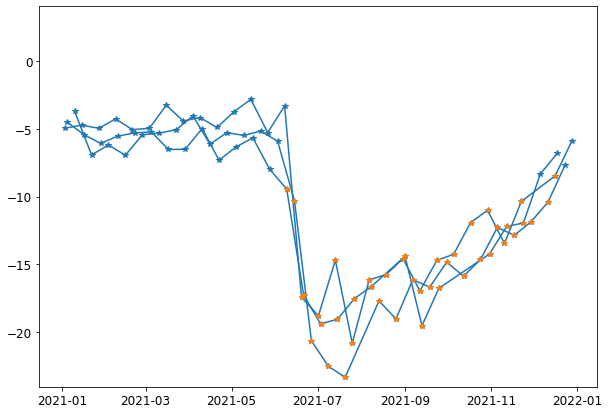

In [16]:
# year = 2020
wstart = datetime(year,1,1,0,0,0)
wend = datetime(year,4,1,1,0,0,0)

# it,jt = 800,835
it,jt = 295,542#This one is nan
it,jt = 815,680
it,jt = 815,580
it,jt = 1230,950
it,jt = 1174,1000
it,jt = 234,567
# it,jt = 1270,980 #front lake, kinda weird
# it,jt = 1295,980


# plt.figure(figsize=(10,7))
# plt.plot(mdatelist,data[:,it,jt],'*')
# plt.ylim([-20,2])

# print(np.shape(mpfulist))
# print(np.shape(

meltvec = getmeltvec(data[:,it,jt],mpfulist,mpfunique,mdatelist,wstart,wend,meltth=-3)
dstart,dend,dstartstd,dendstd = meltseason(meltvec,mdatelist)
print(dendstd)
print(dstart)


plt.figure(figsize=(10,7))
# print(dstartstd)
for pfu in mpfunique:
    # dvec = data[mpfulist==pfu,it,jt]
  
    plt.plot(np.array(mdatelist)[mpfulist==pfu],data[mpfulist==pfu,it,jt],"-*",color='C0')
plt.plot(np.array(mdatelist)[meltvec==1],data[meltvec==1,it,jt],"*",color='C1')
plt.ylim([-24,4])

In [12]:
def getmeltth(dstack,datelist,wstart,wend,meltth=-3):
    #dstack should data. Datelist should be list of dates.
    #Both of these should ONLY be from images of the same path-frame
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    winterlist = np.zeros(len(datelist))
    winterlist[(datelist > wstart) & (datelist < wend)] = 1
    winterlist = np.array(winterlist,dtype=bool)
    # print(winterlist)
    # print(np.shape(dstack))
    dstack = dstack[winterlist]
    # print('###BREAK###')
    # print(np.shape(dstack))
    # dstack[np.isnan(dstack)]=0
    # dstack = np.fliplr(dstack)
    meltdb = np.nanmean(dstack,axis=0)+meltth
    return meltdb
    
# getmeltth(pnamelist,mdatelist,wstart,wend)

In [13]:
def getmeltvec(dvec,pfmulist,pfunique,datelist,wstart,wend,meltth=-3):
    """This will make a vector of melt/nomelt"""
    meltvec = np.zeros(len(dvec))
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    for pfu in pfunique:

        cdata = dvec[mpfulist==pfu]
        cmelt = meltvec[pfmulist==pfu]
        cdatelist = datelist[mpfulist==pfu]
        # cmeltcube = meltcube[mpfulist==pfu]
    
        winterlist = np.zeros(len(cdatelist))
        winterlist[(cdatelist > wstart) & (cdatelist < wend)] = 1
        winterlist = np.array(winterlist,dtype=bool)
        
        # dstack = dstack[winterlist]
        meltdb = np.nanmean(cdata[winterlist],axis=0)+meltth
        cmelt[cdata<meltdb] = 1
        cmelt[np.isnan(cdata)]=np.nan
        meltvec[mpfulist==pfu] = cmelt
        # print(cdata)
    return meltvec

def adjust_dvec(dvec,pfmulist,pfunique,datelist,wstart,wend,setdb=0):
    """adjusts dvec so that the winter mean of each path becomes 0"""
    
    advec = np.zeros(len(dvec))
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    for pfu in pfunique:

        cvec = dvec[pfmulist==pfu]
        # cvec = advec[pfmulist==pfu]
        cdatelist = datelist[pfmulist==pfu]
        # cmeltcube = meltcube[mpfulist==pfu]
    
        winterlist = np.zeros(len(cdatelist))
        winterlist[(cdatelist > wstart) & (cdatelist < wend)] = 1
        winterlist = np.array(winterlist,dtype=bool)
        
        # dstack = dstack[winterlist]
        # print(cvec[winterlist])
        adjustval = np.nanmean(cvec[winterlist],axis=0)+setdb
        
        # cvec[cdata<melt] = 1
        # cvec[np.isnan(cvec)]=np.nan
        advec[mpfulist==pfu] = cvec - adjustval
        # print(cdata)
    return advec

In [14]:
# year = 2021
# wstart = datetime(year,1,1,0,0,0)
# wend = datetime(year,4,1,1,0,0,0)


# print(meltvec)
# data[:,it,jt]

def meltseason(meltvec,datelist):
    """will return the start date and end date of each melt season, as well as the uncertainty of each"""
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    useind = ~np.isnan(meltvec)
    # print(useind)
    meltvec = meltvec[useind]
    datelist = datelist[useind]
    
    mdiff = meltvec[1:]-meltvec[:-1]
    dstart = []
    dstartstd = []
    dend = []
    dendstd = []
    
    # mstartind = np.where(mdiff==1)[0][0]+1
    mstartind = np.where(mdiff==1)

    mstartind = [i+1 for i in mstartind[0]]
    # print(mstartind)
    mlen = len(meltvec)
    
    
    while len(mstartind)>0:
        mstart = mstartind[0]
        # print(mstartind)
        mstartind.remove(mstart)

        #write in the start info
        # print(f'appending {mstart}')
        d1 = datelist[mstart-1]
        d2 = datelist[mstart]
        dstart.append( d1+(d2-d1)/2)
        dstartstd.append((d2-d1).days*0.2886751345) #This is 1/sqrt(12)        
        # print('appending start')
        # print(dstart[-1])
    
        cind = mstart
        lastone = mstart #the last one that was seen. Not the last zero or last two.
        cdstart = dstart[-1]


        # print('found melt')
        # print(cind)
        # print(datelist[cind])
        
        while cind < mlen-1:
            cind+=1
            # print(cind)
            if meltvec[cind]==1.0:
                lastone = cind
                # print('still melt')
                if cind in mstartind:
                    mstartind.remove(cind)
                    # print('removing from start list')
            if meltvec[cind] == 0:
                ddiff = (datelist[cind]-datelist[lastone]).days
                # print('no melt this image')
                if ddiff >= 12:
                    # print('finishing melt')
                    # print(datelist[cind])
                    d1 = datelist[lastone]
                    d2 = datelist[lastone+1]
                    d12diff = (d2-d1).days+(d1-d2).seconds/86400
                    dend.append( d1+timedelta(days=(d12diff)/2))
                    dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)
                    # print('appending end')
                    # print(dend[-1])
                    break

            if cind==mlen-1:
                if meltvec[cind]==1:
                    dendstd.append(np.nan)
                    dend.append(datetime(datelist[-1].year+1,1,1))
                    # dend.append(datelist[-1])
                    
                # if len(dstart)>len(dend):
                else:
                    # dend.append(datetime(datelist[-1].year+1,1,1))
                    d1 = datelist[lastone]
                    d2 = datelist[lastone+1]
                    d12diff = (d2-d1).days+(d1-d2).seconds/86400
                    dend.append( d1+timedelta(days=(d12diff)/2))
                    dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)
                    
                    # dendstd.append(np.nan)

    if len(dstart)>len(dend):
        # dend.append(datelist[-1])
        dend.append(datetime(datelist[-1].year+1,1,1))

        dendstd.append(np.nan)


    return np.array(dstart),np.array(dend),np.array(dstartstd),np.array(dendstd)

In [15]:
#Functions for plotting:

def timediff(time1,time2,form='days'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def create_rasar(dvec,datelist,mpfulist,radays=7):
    """running average from SAR. Converts a list of SAR values into a daily running average"""
    
    year = datelist[0].year
    wstart = datetime(year,1,1,0,0,0)
    start_date = datetime(year,1,1,0,0,0) 
    wend = datetime(year,4,1,0,0,0)
    end_date = datetime(year+1, 1, 1,0,0,0)
    pfunique = np.unique(mpfulist)
    advec = adjust_dvec(dvec,mpfulist,pfunique,datelist,wstart,wend,setdb=0)

    
    delta = end_date - start_date   # returns timedelta
    daylist = []
    for i in range(delta.days + 1):
        daylist.append(start_date + timedelta(days=i))
        # print(day)
    # print(daylist)
    daylist = np.array(daylist)

    if delta.days/len(dvec) > radays/3:
        print('WARNING: raday length is probably too short')
        print(f'consider {delta.days/len(dvec)*3:.2f} days or longer')
    
    daydiff = []
    for day in datelist:
        daydiff.append(timediff(start_date,day,form='days'))
    daydiff = np.array(daydiff)
    
    wstart = datetime(year,1,1,0,0,0)
    wend = datetime(year,4,1,1,0,0,0)
    
    rasar = []
    # dvec = np.array(dvec)     
    # print(len(advec))
    
    for i,day in enumerate(daylist):
        cday = timediff(start_date,day,form='days')
        pts = np.where(np.abs(daydiff - cday)<radays/2)
        rasar.append(np.nanmean(advec[pts]))

    return np.array(rasar),daylist
    # print(cday)
    # print(pts)
    # print(np.array(datelist)[pts])
    # print(np.abs(daydiff - cday)<radays/2)
    # print(daydiff)

# print(data[:,it,jt])

def rasar_smoothing(rasar, daylist,radays=7,smoothing='dayhour'):
    
    #interpolate nans
    nvals = np.where(np.isnan(rasar))[0]
    svals = np.where(~np.isnan(rasar))[0]
    for i,s in enumerate(svals[:-1]):
        svdiff = svals[i+1]-svals[i]
        if svdiff>1:
            r1 = rasar[svals[i]]
            r2 = rasar[svals[i+1]]
            rdiff = r2-r1
            for j in range(1,svdiff):
                rasar[s+j] = r1+j*rdiff/svdiff
    
    rasmooth=[]
    # start_date = daylist[0]
    daydiff = np.arange(len(rasar))
    
    for i in daydiff:
        # cday = timediff(start_date,day,form='days')
        pts = np.where(np.abs(daydiff - i)<radays/2)
        rasmooth.append(np.mean(rasar[pts]))
    
    return np.array(rasmooth)
    
    #HOUR technique probably not necessary
    # rasardh = []
    # dayhour = []
    # hourlist = range(24)
    # for i,day in enumerate(daylist[:-1]):
    #     day2 = daylist[i+1]
    #     sar1 = rasar[i]
    #     sar2 = rasar[i+1]
    #     sdiff = sar2-sar1
    #     for hour in hourlist:
    #         rasar

/tmp/ipykernel_176/3089024976.py:46: RuntimeWarning: Mean of empty slice
  adjustval = np.nanmean(cvec[winterlist],axis=0)+setdb
/tmp/ipykernel_176/2373038611.py:54: RuntimeWarning: Mean of empty slice
  rasar.append(np.nanmean(advec[pts]))
/tmp/ipykernel_176/3089024976.py:46: RuntimeWarning: Mean of empty slice
  adjustval = np.nanmean(cvec[winterlist],axis=0)+setdb
/tmp/ipykernel_176/2373038611.py:54: RuntimeWarning: Mean of empty slice
  rasar.append(np.nanmean(advec[pts]))


consider 6.15 days or longer
consider 6.15 days or longer


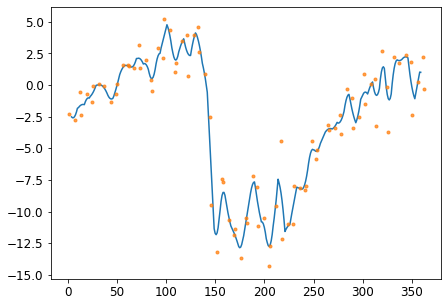

In [30]:
it,jt = 234,567
rasar,daylist = create_rasar(data[:,it,jt],mdatelist,mpfulist,radays=1)
# print(rasar)
rasmooth = rasar_smoothing(rasar,daylist)
# print(rasar)
# print(timediff(datetime(2021,1,1,0,0,0),datetime(2022,1,1,0,0,0),form='days'))
# print(np.isnan(rasar))

plt.figure(figsize=(7,5))
plt.plot(rasmooth,'-')
rasar,daylist = create_rasar(data[:,it,jt],mdatelist,mpfulist,radays=1)
# rasar = rasar_smoothing(rasar,daylist,radays=1)
plt.plot(rasar,'.',alpha=.75)
plt.savefig(data_dir/'figures'/f'pt_i{it}_j{jt}.png')
# plt.plot(data[:,it,jt],'.')
# data[:,it,jt]

In [46]:
# it,jt = 825,835
it,jt = 800,825
meltvec = getmeltvec(data[:,it,jt],mpfulist,mpfunique,mdatelist,wstart,wend)
dstart,dend,dstartstd,dendstd = meltseason(meltvec,mdatelist)

mslen = []
mssig = []
for i,x in enumerate(dstart):
    mslen.append((dend[i]-dstart[i]).days+(dend[i]-dstart[i]).seconds/86400)
    mssig.append(np.sqrt(dstartstd[i]**2+dendstd[i]**2))
print(dstart)
print(dend)
print(' ')
print(dstartstd)
print(dendstd)
print(' ')
print(mslen)
print(mssig)

mslen = []
mssigsum = 0

for i,x in enumerate(dstart):
    mslen.append((dend[i]-dstart[i]).days+(dend[i]-dstart[i]).seconds/86400)
    # mssig.append(np.sqrt(dstartstd[i]**2+dendstd[i]**2))
    mssigsum += dstartstd[i]**2+dendstd[i]**2
mssig = np.sqrt(mssigsum)

print(' ')
print(mssig)

[datetime.datetime(2021, 4, 18, 3, 52, 20, 500000)
 datetime.datetime(2021, 10, 3, 3, 52, 29)
 datetime.datetime(2021, 10, 27, 3, 52, 29)
 datetime.datetime(2021, 12, 26, 3, 52, 27)]
[datetime.datetime(2021, 5, 18, 20, 40, 19)
 datetime.datetime(2021, 10, 15, 15, 44, 11)
 datetime.datetime(2021, 10, 30, 10, 23, 25)
 datetime.datetime(2022, 1, 1, 0, 0)]
 
[1.44337567 1.44337567 1.44337567 1.44337567]
[1.57863868 1.73038692 0.44375115        nan]
 
[30.69997685185185, 12.49423611111111, 3.2714814814814814, 5.838576388888889]
[2.1390262795986614, 2.2533468906592407, 1.5100491431120135, nan]
 
nan


/tmp/ipykernel_410/3105575282.py:19: RuntimeWarning: Mean of empty slice
  meltdb = np.nanmean(cdata[winterlist],axis=0)+meltth


Criteria for melt:

Option 1:
1. Two positive identifications of melt within 12.5 days (to allow for satellite overpass on same orbit)
2. Melt seasons are divided into these dates

Option 2:
1. Melt starts with a single positive identification of melt.
2. Melt ends if there is no positive identifications of melt over the next 12 days (assuming there is any data, but there should be because of the 12 day list).

In each case, melt starts or end at time b-(b-a)/2 for a: last confirmed melt/no-melt, b: first melt/no-melt. The 1-sigma
uncertainty is (b-a)/sqrt(12)

In [161]:
klen,ilen,jlen = np.shape(data)

test1 = np.zeros((ilen,jlen))
np.save(f'{str(data_dir)}/meltseason.npy',test1)
print('something')

something


In [35]:
meltvec2 = meltvec[~np.isnan(meltvec)]
test = np.arange(12)
test[::5]
mdiff = meltvec2[1:]-meltvec2[:-1]
np.where(mdiff==1)[0][0]
mdatelist[14]+(mdatelist[15]-mdatelist[14])/2
(mdatelist[18]-mdatelist[14]).days/np.sqrt(12)

3.1754264805429417

In [73]:
klen,ilen,jlen = np.shape(data)
# istart,jstart = 715,0
istart,jstart = 0,0
#produce meltstart map
meltstart = np.zeros((ilen,jlen),dtype=object)
meltlength = np.zeros((ilen,jlen))
meltlenstd = np.zeros((ilen,jlen))
loaddata = False
# if loaddata==True:
savedata = True

for ii in range(istart,ilen):
    # print(f'{ii}\r',end='')
    if ii%5==0:
        if savedata:
            np.save(f'{str(data_dir)}/meltseason.npy',(meltstart,meltlength,meltlenstd))
    for jj in range(jstart,jlen):
        if jj%50==0:
            print(f'{ii}, {jj}\r',end='')
        # if jj%10==0:
        meltvec = getmeltvec(data[:,ii,jj],mpfulist,mpfunique,mdatelist,wstart,wend)
        dstart,dend,dstartstd,dendstd = meltseason(meltvec,mdatelist)
        mslen = []
        mssigsum = 0
        
        for i,x in enumerate(dstart):
            mslen.append((dend[i]-dstart[i]).days+(dend[i]-dstart[i]).seconds/86400)
            # mssig.append(np.sqrt(dstartstd[i]**2+dendstd[i]**2))
            mssigsum += dstartstd[i]**2+dendstd[i]**2
        mssig = np.sqrt(mssigsum)

        if len(dstart)==0:
            dstart = [np.nan]
        meltstart[ii,jj] = dstart[0]
        meltlength[ii,jj] = np.sum(mslen)
        meltlenstd[ii,jj] = mssig
        
        # mslen = (dend-dstart).days+(dend-dstart).seconds/86400
        # mssig = np.sqrt(dstartstd**2+dendstd**2)

/tmp/ipykernel_410/3105575282.py:19: RuntimeWarning: Mean of empty slice
  meltdb = np.nanmean(cdata[winterlist],axis=0)+meltth


test
128 days, 3:11:31.500000


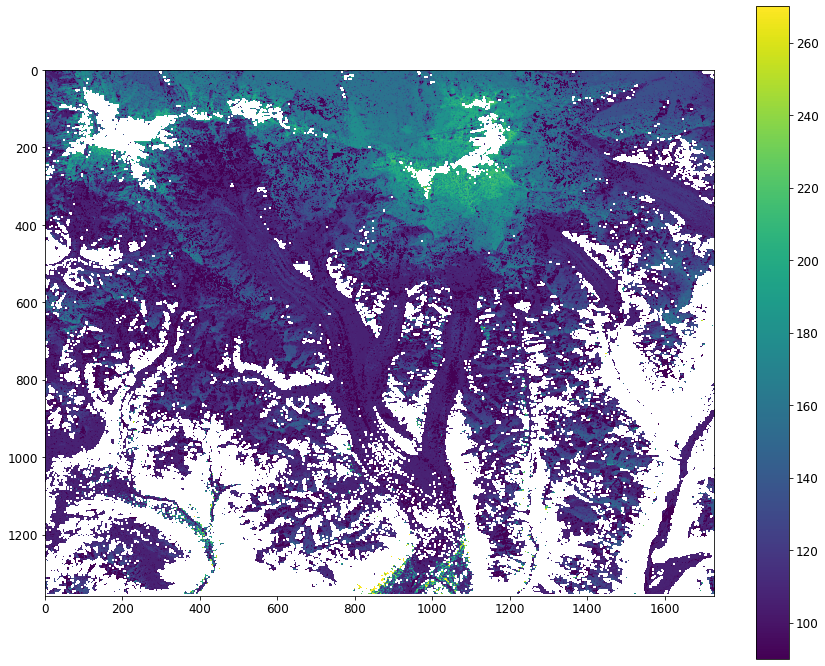

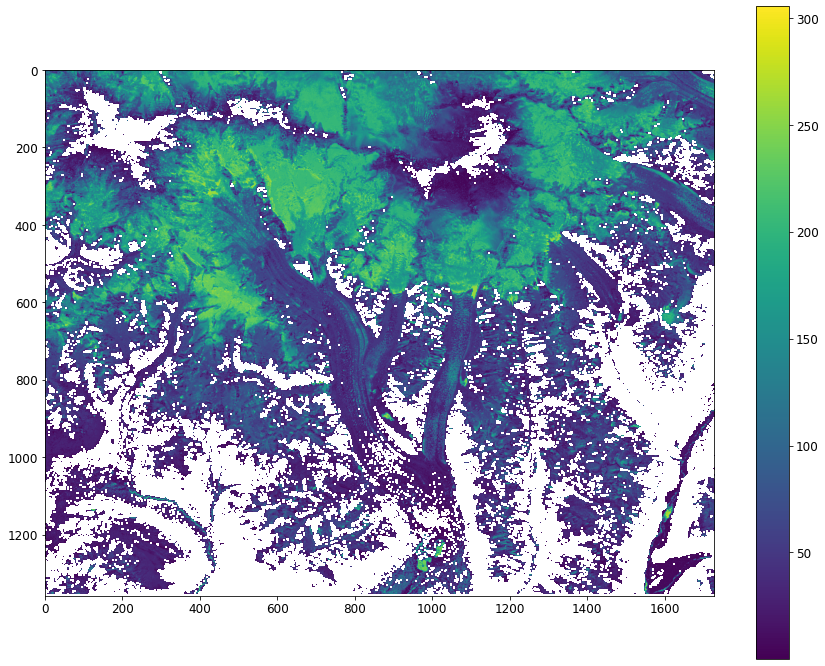

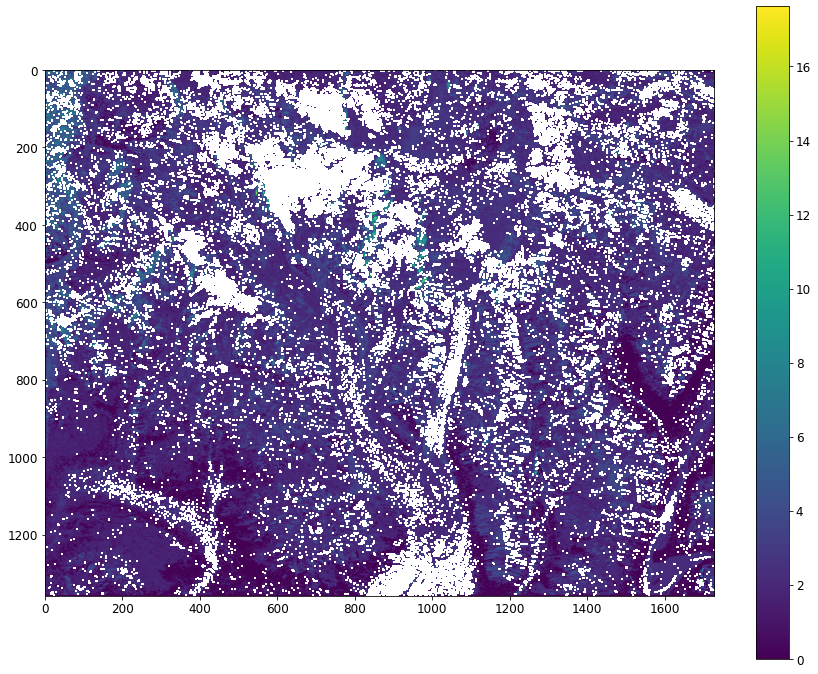

In [40]:
print(str(data_dir))
klen,ilen,jlen = np.shape(data)
meltstart,meltlength,meltlenstd = np.load(f'{str(data_dir)}/meltseason.npy',allow_pickle=True)
# print(meltlenstd.dtype)
meltlength = np.array(meltlength,dtype='float64')
meltlenstd = np.array(meltlenstd,dtype='float64')


# plt.figure(figsize=(14,12))
# plt.imshow(meltlength,vmax=275)
# plt.colorbar()
# plt.savefig('test/testimg.png')

year = meltstart[0,0].year
yearstart = datetime(year,1,1)
print(meltstart[0,0]-yearstart)
# meltstartdiff = meltstart-yearstart
meltstartday = np.zeros((ilen,jlen))
for ii in range(ilen):
    for jj in range(jlen):

        if type(meltstart[ii,jj])==type(yearstart):
            meltstartdiff = meltstart[ii,jj]-yearstart 
            meltstartday[ii,jj] = meltstartdiff.days+meltstartdiff.seconds/86400
        else:
            meltstartday[ii,jj] = np.nan
            
plt.figure(figsize=(15,12))
plt.imshow(meltstartday,vmin=90,vmax=270)
plt.colorbar()
plt.savefig('test/meltstartday.png')

meltlength[meltlength==0] = np.nan
plt.figure(figsize=(15,12))
plt.imshow(meltlength)
plt.colorbar()
plt.savefig('test/meltlength.png')

plt.figure(figsize=(15,12))
plt.imshow(meltlenstd)
plt.colorbar()
plt.savefig('test/meltlenstd.png')

In [29]:
np.array(meltlength,dtype='float64')

# print(np.array(np.zeros((5,5))+2.1).dtype)

# type(meltstart[ii,jj])
# meltstart[ii,jj]
# print(np.shape(mdatelist))
# print(mdatelist)
#test this out
# mdatelist = np.array(mdatelist)
# meltdb = getmeltth(data,mdatelist,wstart,wend,meltth=-3)

## NOTHING OF VALUE BELOW THIS

* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
* 
**
*
*
*
***
***
***
***
***
***
***
***
***
***


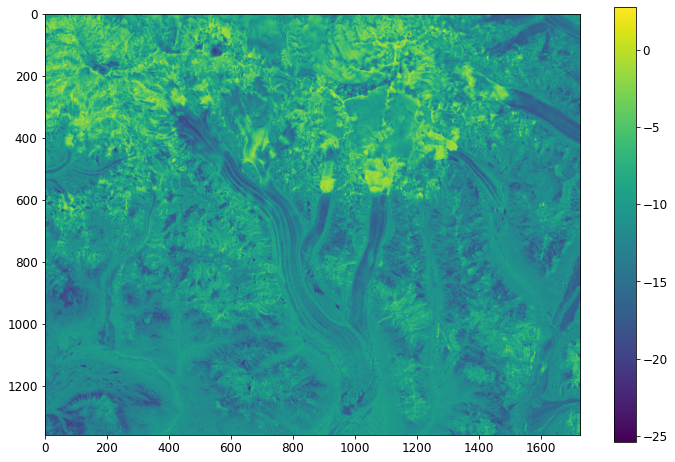

In [20]:
# test = np.nanmean(data,axis=0)
plt.figure(figsize=(12,8))
plt.imshow(meltdb)
plt.colorbar()

In [33]:
year = 2021
wstart = datetime(year,1,1,0,0,0)
wend = datetime(year,4,1,1,0,0,0)
meltth=-3

meltcube = np.zeros(np.shape(data))
mdatelist = np.array(mdatelist)

for pfu in mpfunique:
    cdata = data[mpfulist==pfu]
    cdatelist = mdatelist[mpfulist==pfu]
    cmeltcube = meltcube[mpfulist==pfu]
    print(len(cdatelist))
    print(len(cdatelist))
    meltdb = getmeltth(cdata,cdatelist,wstart,wend,meltth=meltth)
    cmeltcube[cdata<=meltdb]=1
    meltcube[mpfulist==pfu]=cmeltcube
    print(np.nansum(cmeltcube))
    # print(np.shape(cdata))
meltcube[np.isnan(data)]=np.nan
print(np.nansum(meltcube))

29
29


/tmp/ipykernel_175/3754147295.py:20: RuntimeWarning: Mean of empty slice
  meltdb = np.nanmean(dstack,axis=0)-3


9687442.0
27
27
7823073.0
27
27
2973374.0
30
30
10833223.0
30
30
176494.0
30
30
3328190.0
34821796.0


In [21]:
for i,name in enumerate(mnamelist):

    fname = f'{str(data_dir)}/figures/MELT_{name}.png'
    # fname = file.replace(fileloc,figurepath)
    # fname = fname.replace('_VV.tif','.png')
    fname = fname.replace('S1A_','')
    fname = fname.replace('S1B_','')
    # ds = gdal.Open(file)
    # sarmap = ds.ReadAsArray()
    # ds = None
    # sarmap[sarmap<-40]=np.nan
    plt.figure(figsize=(7,7))
    plt.imshow(meltcube[i],vmin=0,vmax=1)#,cmap='Greys_r')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.savefig(fname,bbox_inches='tight')
    plt.close()
    
#Note: This significantly increases memory usage and I can't figure out how to reduce that

In [165]:
# print(mdatelist)
scf = 4
test1 = np.random.normal(5,scf,size=(100000,2))
test2 = np.random.normal(5,scf,size=(100000,2))
test3 = np.random.normal(5,scf,size=(100000,2))
# testsum = np.sum(test,axis=1)
testdiff = test[:,1]-test[:,0]
print(np.std(testdiff))
print(np.sqrt((scf**2+scf**2)))

testfull = (test1[:,1]-test1[:,0])+(test2[:,1]-test2[:,0])+(test3[:,1]-test3[:,0])
print(np.shape(testfull))
print(np.std(testfull))
print(np.sqrt(6*scf**2))

5.6598230879834155
5.656854249492381
(100000,)
9.784596816084948
9.797958971132712


When is melt?
I can make a map to show when melt starts and when it ends

In [11]:
def timediff(time1,time2,form='seconds'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

In [12]:
yrstart = datetime(year,1,1,0,0,0)

tdlist = []
for date in mdatelist:
    tdlist.append(timediff(yrstart,date,'days'))
tdlist = np.array(tdlist)

In [35]:
#now, I need a function to determine the start of melt for each pixel

meltstartmap = np.zeros(np.shape(meltcube[0]))
def meltstart(meltvec):
    '''NOTE: THIS IS CRUDE AT THE MOMENT. IT SHOULD BE IMPROVED'''
    print(np.where(meltvec==1)[0][0])
    # meltstartind = np.where(meltvec==1)
    
meltstart(meltcube[:,450,750])
#THIS IS THE RIGHT WAY, BUT I WILL TRY SOMETHING ELSE FIRST

68


In [13]:
year = 2021
from datetime import date, timedelta

# start_date = date(2008, 8, 15) 
end_date = datetime(year+1, 1, 1,0,0,0)    # perhaps date.now()

delta = end_date - yrstart   # returns timedelta
daylist = []
for i in range(delta.days + 1):
    daylist.append(yrstart + timedelta(days=i))
    # print(day)
# print(daylist)
daylist = np.array(daylist)

In [37]:
#Clear up some space if necessary:
data = None

In [54]:
ilen,jlen = np.shape(meltcube[0])
mcb = np.zeros((len(daylist),ilen,jlen)) #meltcube b?
print(np.shape(mcb))
# mcb = None
# for i in range(len(mcb)):
    # mcb[i]=meltcube[50]

(366, 1358, 1729)


In [5]:
#ok do on a pix by pix basis, then see if you can refactor later
dayrange = np.arange(len(daylist))

for i in range(ilen):
    if i%1==0:
        print(f'{i}\r',end='')
    for j in range(jlen):
        mvec = meltcube[:,i,j]
        # mcbvec = mcb[:,i,j]
        tdlc = tdlist[~np.isnan(mvec)]
        mvec = mvec[~np.isnan(mvec)]
        for k,mval in enumerate(mvec[:-1]):
            t1 = tdlc[k]
            t2 = tdlc[k+1]
            td = t2-t1
            # if td<1 and #Have better conditions here, but this isn't what's slow I don't think
            if td > .1:
                m1 = mvec[k]
                m2 = mvec[k+1]
                md = m2-m1
                dmdt = md/td
                ll = dayrange[np.where((dayrange > t1) & (dayrange < t2))]
                if len(ll)>=1:
                    for l in ll:
                        mcb[l,i,j] = m1+(l-t1)*dmdt
                    # daydelta = ll-t1
                    
                    
np.save('mcb.npy',mcb)                    

NameError: name 'daylist' is not defined

In [6]:
# np.where((daylist > tdlist[5]) & (daylist < tdlist[10]))
mcb = np.load('mcb.npy')

In [74]:
dayrange[np.where((dayrange > t1) & (dayrange < t2))]

array([76, 77, 78, 79, 80])

In [17]:
plt.figure(figsize=(6,6))
for i,mc in enumerate(mcb):
    # plt.imshow(mc,vmin=0,vmax=1)
    # if i==0:
        # plt.colorbar()
    fname = f'{data_dir}/dayview/day_{i}.png'
    dstr = str(daylist[i])
    plt.figure(figsize=(6,6))
    plt.imshow(mc,vmin=0,vmax=1)
    ax = plt.gca()
    plt.text(5,5,dstr)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.savefig(fname,bbox_inches='tight')
    plt.close()

In [1]:
meltlength

NameError: name 'meltlength' is not defined